In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras import layers
from keras.layers import Dense, Concatenate, Dropout, BatchNormalization
from keras.utils.vis_utils import plot_model
 
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
import scipy as sp
import seaborn as sns

import numpy as np

import pandas as pd
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from tabulate import tabulate

import time

from multiprocessing import Pool
from joblib import Parallel, delayed
import concurrent.futures

import pickle
import os

data_path  = './Dataset_Cleaned/'
model_path = './Model_Saved/'
newdata_path = './v6_A-B-C-D-E_Sputtering_ML_master/v6_A-B-C-D-E_Sputtering_ML_KW/'

# ----- BO-related -----
notebook_fname = "NN_full_RepeatedKFold_v3_BO_2"
num_str        = notebook_fname.split("_")[-1]

model_path_bo = f'{model_path}/{notebook_fname}/'

if not os.path.exists(model_path_bo):
    os.makedirs(model_path_bo)
    print(f"Folder '{model_path_bo}' created.")
else:
    print(f"Folder '{model_path_bo}' model path found.")
# ----- BO-related -----

tf.keras.backend.clear_session()

2023-06-02 17:55:56.695761: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-02 17:56:01.274033: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-06-02 17:56:01.274704: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-06-02 17:56:01.274715

Folder './Model_Saved//NN_full_RepeatedKFold_v3_BO_2/' model path found.


#### load scalers

In [2]:
# Load the scalers from the file
with open(data_path + 'scalers.pkl', 'rb') as f:
    (scaler_compo, 
     scaler_H_specific, 
     scaler_C_specific, 
     scaler_H_output, 
     scaler_C_output) = pickle.load(f)

#### coordinates for PVD alloy representation

In [3]:
# load the wafer-coordinates
df_PVD_x_y = pd.read_excel(data_path + 'PVD_x_y.xlsx')
coord_x = df_PVD_x_y["x"].to_numpy(dtype=float)
coord_y = df_PVD_x_y["y"].to_numpy(dtype=float)
index_PVD_x_y = df_PVD_x_y.index.values+1
 

#### define `read_new_data` to load the inputs for making predictions

In [4]:
def read_new_data(df_new_at, df_new_wt, vars_ele): 
       
       # ----- import the new dataset ----- 
       vars_ele  = vars_ele

       # ----- get the `df_compo_new` ------
       df_compo = pd.DataFrame(columns=['Fe', 'Cr', 'Ni', 'Mo', 'W', 'N', 'Nb', 'C', 'Si', 'Mn',
              'Cu', 'Al', 'V', 'Ta', 'Ti', 'Co', 'Mg', 'Y', 'Zr', 'Hf'])

       df_compo_new = pd.concat([df_compo, df_new_wt[vars_ele]], axis=0, ignore_index=True)
       df_compo_new = df_compo_new.fillna(0) # fill in the nan by zero

       compo_new    = np.asarray(df_compo_new.values)

       # ----- get the `df_H_specific_new` ----- 
       df_H_specific_new = df_new_at[['delta_a', 'Hmix', 'VEC', 'sigma_bulk_modulus']]

       H_specific_new = np.asarray(df_H_specific_new.values)


       # ----- get the `df_C_specifi_new` ----- 
       C_testing = np.array([25, 1, 7, 0.3334]) # TestTemperature_C, ChlorideIonConcentration, pH, ScanRate_mVs
       C_specific_new = np.ones((len(df_compo_new. index), len(C_testing))) * C_testing # corrosion testing condition array
       # df_C_specific_new = pd.DataFrame(C_specific_new, columns=['TestTemperature_C', 'ChlorideIonConcentration', 'pH', 'ScanRate_mVs'])

       return compo_new, H_specific_new, C_specific_new


#### define `predict_bootstrap_NNH_NNC` for predictions from NNH and NNC

In [5]:
def predict_bootstrap(model_path, model_name,
                      X1_list, Y1_list, 
                      k_folds, n_CVrepeats, mc_repeat,
                      scaler_compo, scaler_H_specific, scaler_output):
    
    H1_pred_X1_list    = []
    H1_pred_X1_mc_mean = []
    H1_pred_X1_mc_std  = []
    
    def predict_one_model(i):

        # loading saved models
        NNH_model_loaded_temp = keras.models.load_model(os.path.join(model_path, model_name.format(i+1)))
        
        # make prediction
        def predict_one_sample():
            return scaler_output.inverse_transform(
                NNH_model_loaded_temp.predict([scaler_compo.transform(X1_list[i]), 
                                                   scaler_H_specific.transform(Y1_list[i])], 
                                                   verbose = 0)
                                                  )
            
        H1_pred_X1_mc_stack_temp = tf.map_fn(lambda _: predict_one_sample(),
                                             tf.range(mc_repeat),
                                             dtype=tf.float32,
                                             parallel_iterations=mc_repeat)
        
        H1_pred_X1_mc_mean_temp = np.mean(H1_pred_X1_mc_stack_temp, axis = 0).reshape((-1,))
        H1_pred_X1_mc_std_temp  = np.std(H1_pred_X1_mc_stack_temp,  axis = 0).reshape((-1,))
        
        return H1_pred_X1_mc_stack_temp, H1_pred_X1_mc_mean_temp, H1_pred_X1_mc_std_temp
    
    results = Parallel(n_jobs=-1)(delayed(predict_one_model)(i) for i in range(k_folds * n_CVrepeats))
    
    # clear TensorFlow session
    tf.keras.backend.clear_session()

    for mc_stack, mean, std in results:
        H1_pred_X1_list.append(mc_stack)
        H1_pred_X1_mc_mean.append(mean)
        H1_pred_X1_mc_std.append(std)

    return H1_pred_X1_list, H1_pred_X1_mc_mean, H1_pred_X1_mc_std

In [6]:
def predict_bootstrap_NNH_NNC(model_path_bo, NNH_model_name, NNC_model_name,
                               compo_new, H_specific_new, C_specific_new,
                               scaler_compo, scaler_H_specific, scaler_C_specific,
                               scaler_H_output, scaler_C_output,
                               k_folds, n_CVrepeats, mc_repeat):
    
    # Repeat new data to match number of CV repetitions
    compo_new_list = [compo_new]*k_folds*n_CVrepeats
    H_specific_new_list = [H_specific_new]*k_folds*n_CVrepeats
    C_specific_new_list = [C_specific_new]*k_folds*n_CVrepeats

    # Predict using bootstrap resampling in parallel
    with concurrent.futures.ThreadPoolExecutor() as executor:
        future1 = executor.submit(predict_bootstrap, model_path_bo, NNH_model_name, 
                                                 compo_new_list, H_specific_new_list, 
                                                 k_folds, n_CVrepeats, mc_repeat,
                                                 scaler_compo, scaler_H_specific, scaler_H_output)
        future2 = executor.submit(predict_bootstrap, model_path_bo, NNC_model_name, 
                                                 compo_new_list, C_specific_new_list, 
                                                 k_folds, n_CVrepeats, mc_repeat,
                                                 scaler_compo, scaler_C_specific, scaler_C_output)

    # Retrieve results from parallel predictions
    H1_new_pred_stack, H1_new_pred_mean, H1_new_pred_std = future1.result()
    C2_new_pred_stack, C2_new_pred_mean, C2_new_pred_std = future2.result()
    
    return H1_new_pred_stack, H1_new_pred_mean, H1_new_pred_std, C2_new_pred_stack, C2_new_pred_mean, C2_new_pred_std

#### define `plot_prediction_uncertainty` for prediction and uncertainty for each fold in bootstrap on wafer-coordinates

In [7]:
def plot_prediction_uncertainty(coord_x, coord_y, index_PVD_x_y, 
                                pred_mean, pred_std, pred_label, unc_label, 
                                title, vmin1, vmax1, vmin2, vmax2, model_path):
    
    fig, axs = plt.subplots(nrows=4, ncols=6, figsize=(18, 10), dpi=200)

    for i, (ax_pred, ax_unc) in enumerate(zip(axs[::2].flat, axs[1::2].flat)):
        # ----- subplot 1 prediction -----
        cax1 = ax_pred.scatter(coord_x, coord_y, c=pred_mean[i], s=400, marker='.', cmap='RdBu_r', vmin=vmin1, vmax=vmax1)
        ax_pred.set_xlabel('X')
        ax_pred.set_ylabel('Y')
        ax_pred.set_title(f'prediction {i+1}', fontsize=8)
        ax_pred.set_aspect('equal', 'box')
        for i_pvd, txt in enumerate(index_PVD_x_y):
            ax_pred.annotate(txt, (coord_x[i_pvd]-2, coord_y[i_pvd]-1), color="grey", alpha=1, fontsize=8)

        cbar1 = fig.colorbar(cax1, ax=ax_pred)
        cbar1.set_label(pred_label, size=8)
        cbar1.ax.tick_params(labelsize=8)

        # ----- subplot 2 prediction uncertainty -----
        cax2 = ax_unc.scatter(coord_x, coord_y, c=pred_std[i], s=400, marker='.', cmap='RdGy_r', vmin=vmin2, vmax=vmax2)
        ax_unc.set_xlabel('X')
        ax_unc.set_ylabel('Y')
        ax_unc.set_title(f'prediction uncertainty {i+1}', fontsize=8)
        ax_unc.set_aspect('equal', 'box')
        for i, txt in enumerate(index_PVD_x_y):
            ax_unc.annotate(txt, (coord_x[i]-3, coord_y[i]-1.5), color="grey", alpha=1, fontsize=8)

        cbar2 = fig.colorbar(cax2, ax=ax_unc)
        cbar2.set_label(unc_label, size=8)
        cbar2.ax.tick_params(labelsize=8)
        # -----------------------------------

    # adjust spacing and show plot
    plt.suptitle(title, fontsize=18)
    fig.tight_layout()
    plt.savefig(model_path + title + '.png', bbox_inches='tight')
    plt.show()


#### define `plot_prediction_uncertainty_AVG` for prediction and uncertainty for averaged bootstarp on wafer-coordinates

In [8]:
def plot_prediction_uncertainty_AVG(coord_x, coord_y, index_PVD_x_y, H1_new_pred_stack, C2_new_pred_stack, 
                                    title, KW_name, model_path_bo):
    
    # ----- concatenate and compute mean and std -----
    H1_new_pred_KFold_mean = np.mean(np.concatenate(H1_new_pred_stack, axis=0), axis=0).reshape(-1)
    H1_new_pred_KFold_std  = np.std(np.concatenate(H1_new_pred_stack, axis=0), axis=0).reshape(-1)

    C2_new_pred_KFold_mean = np.mean(np.concatenate(C2_new_pred_stack, axis=0), axis=0).reshape(-1)
    C2_new_pred_KFold_std  = np.std(np.concatenate(C2_new_pred_stack, axis=0), axis=0).reshape(-1)

    # ----- plot true vs prediction for all the RepeatedKFold + MC_dropout -----
    # Set font size for all text in figure
    plt.rcParams.update({'font.size': 8})

    # Create figure with 2 subplots
    fig, ax = plt.subplots(2, 2, figsize=(6, 5), dpi=200)

    # Define plot details
    plot_details = [(H1_new_pred_KFold_mean, H1_new_pred_KFold_std, 'Hardness', ''),    
                    (C2_new_pred_KFold_mean, C2_new_pred_KFold_std, 'Pitting potential', '(mV)')]

    # Loop through plot details and create subplots
    for i, (mean, std, name, unit) in enumerate(plot_details):
        row, col = i // 2, i % 2
        cmap1, cmap2 = plt.get_cmap('RdBu_r'), plt.get_cmap('RdGy_r')
        cax1 = ax[row, col].scatter(coord_x, coord_y, c=mean, s=400, marker='.', cmap=cmap1)
        cax2 = ax[row+1, col].scatter(coord_x, coord_y, c=std, s=400, marker='.', cmap=cmap2)
        ax[row, col].set_title(f'{name} ')
        ax[row+1, col].set_title(f'{name}  uncertainty')
        ax[row, col].set_aspect('equal')
        ax[row+1, col].set_aspect('equal')
        ax[row, col].set_xlabel('X')
        ax[row, col].set_ylabel('Y')
        ax[row+1, col].set_xlabel('X')
        ax[row+1, col].set_ylabel('Y')
        for i_pvd, txt in enumerate(index_PVD_x_y):
            ax[row, col].annotate(txt, (coord_x[i_pvd]-3, coord_y[i_pvd]-1.5), color="grey", alpha=1)
            ax[row+1, col].annotate(txt, (coord_x[i_pvd]-3, coord_y[i_pvd]-1.5), color="grey", alpha=1)
        cbar1, cbar2 = fig.colorbar(cax1, ax=ax[row, col]), fig.colorbar(cax2, ax=ax[row+1, col])
        cbar1.set_label(f'{name}  {unit}')
        cbar2.set_label(f'{name}  uncertainty {unit}')

    # adjust spacing and show plot
    plt.suptitle(title, fontsize=10)

    # Save and show figure
    fig.tight_layout()
    plt.savefig(model_path_bo + 'NN_full_RepeatedKFold_prediction_uncertainty_AVG_' + KW_name + '.png', bbox_inches='tight')
    plt.show()

#### make predictions for new alloys 

In [9]:
compo_A_B_C_D_E_list = [['Ni', 'Cr', 'Co', 'V', 'Fe'],  
                        ['Ni', 'Cr', 'Mo', 'Ti', 'Fe']]

compo_A_B_C_D_E_fname_list = ['KW99', 'KW131']
  

Processing:   0%|          | 0/2 [00:00<?, ?it/s]

['Ni', 'Cr', 'Co', 'V', 'Fe']
KW99


2023-06-02 17:56:22.242730: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-02 17:56:22.277222: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-02 17:56:22.281079: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuil

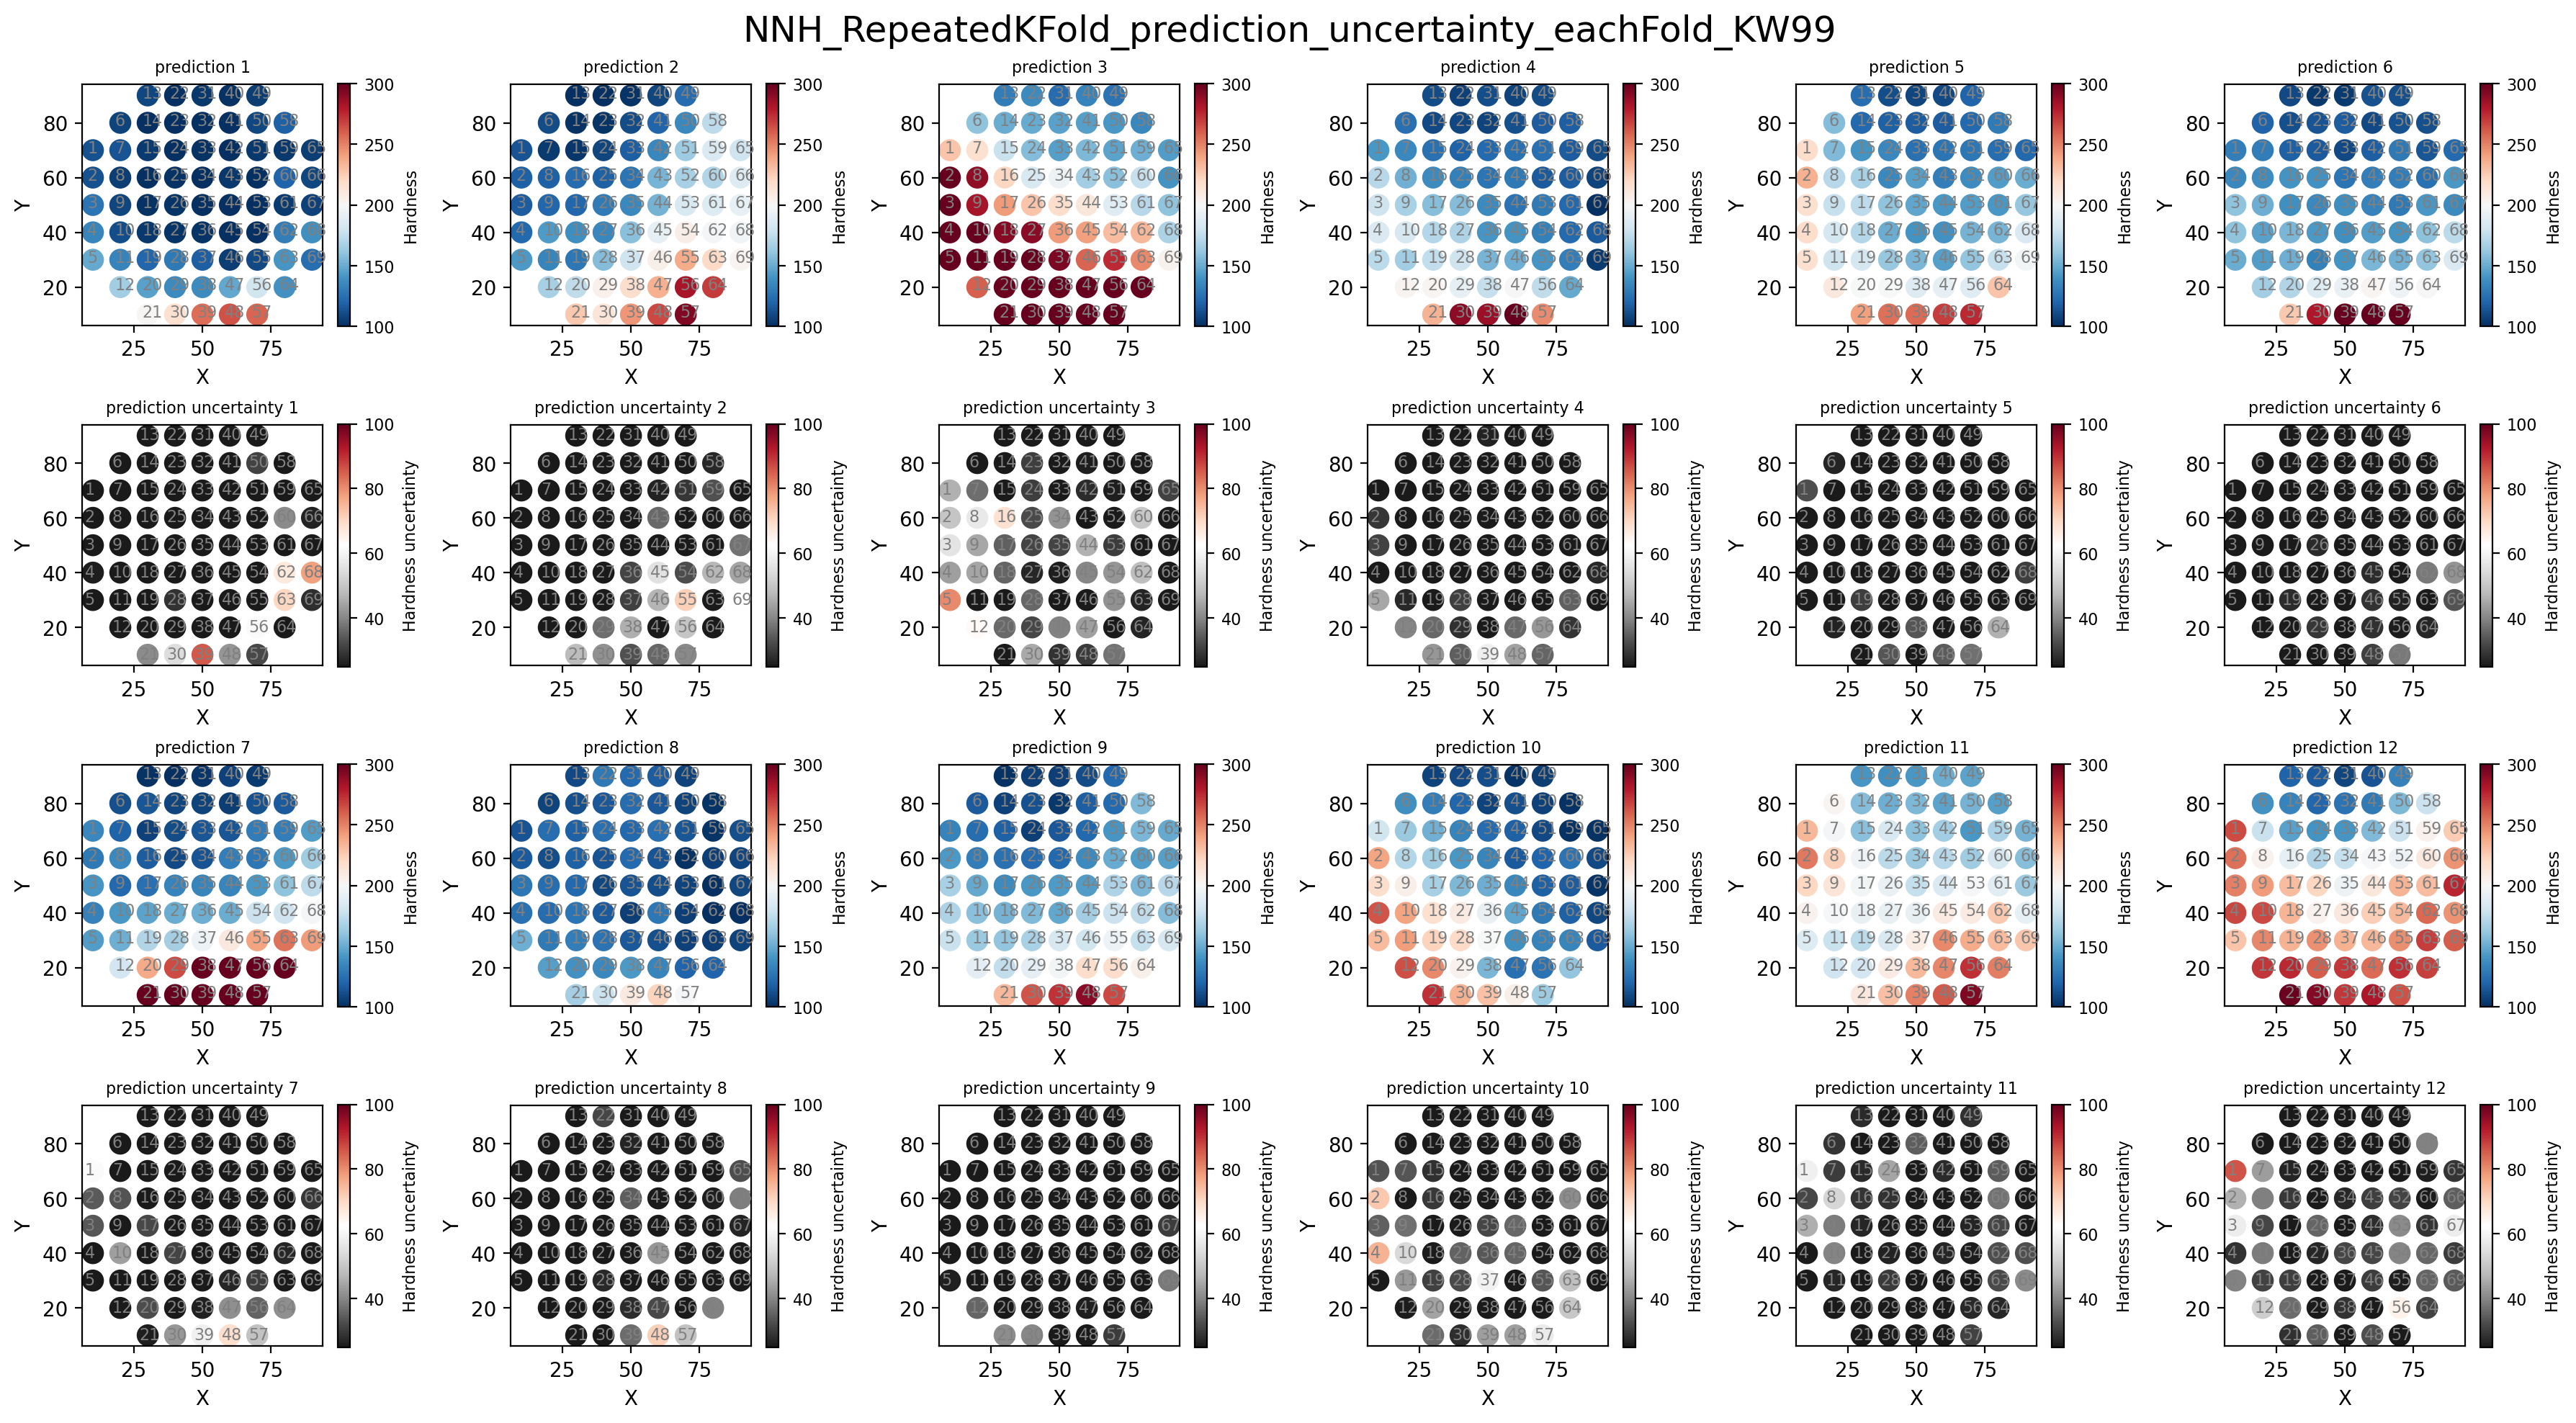

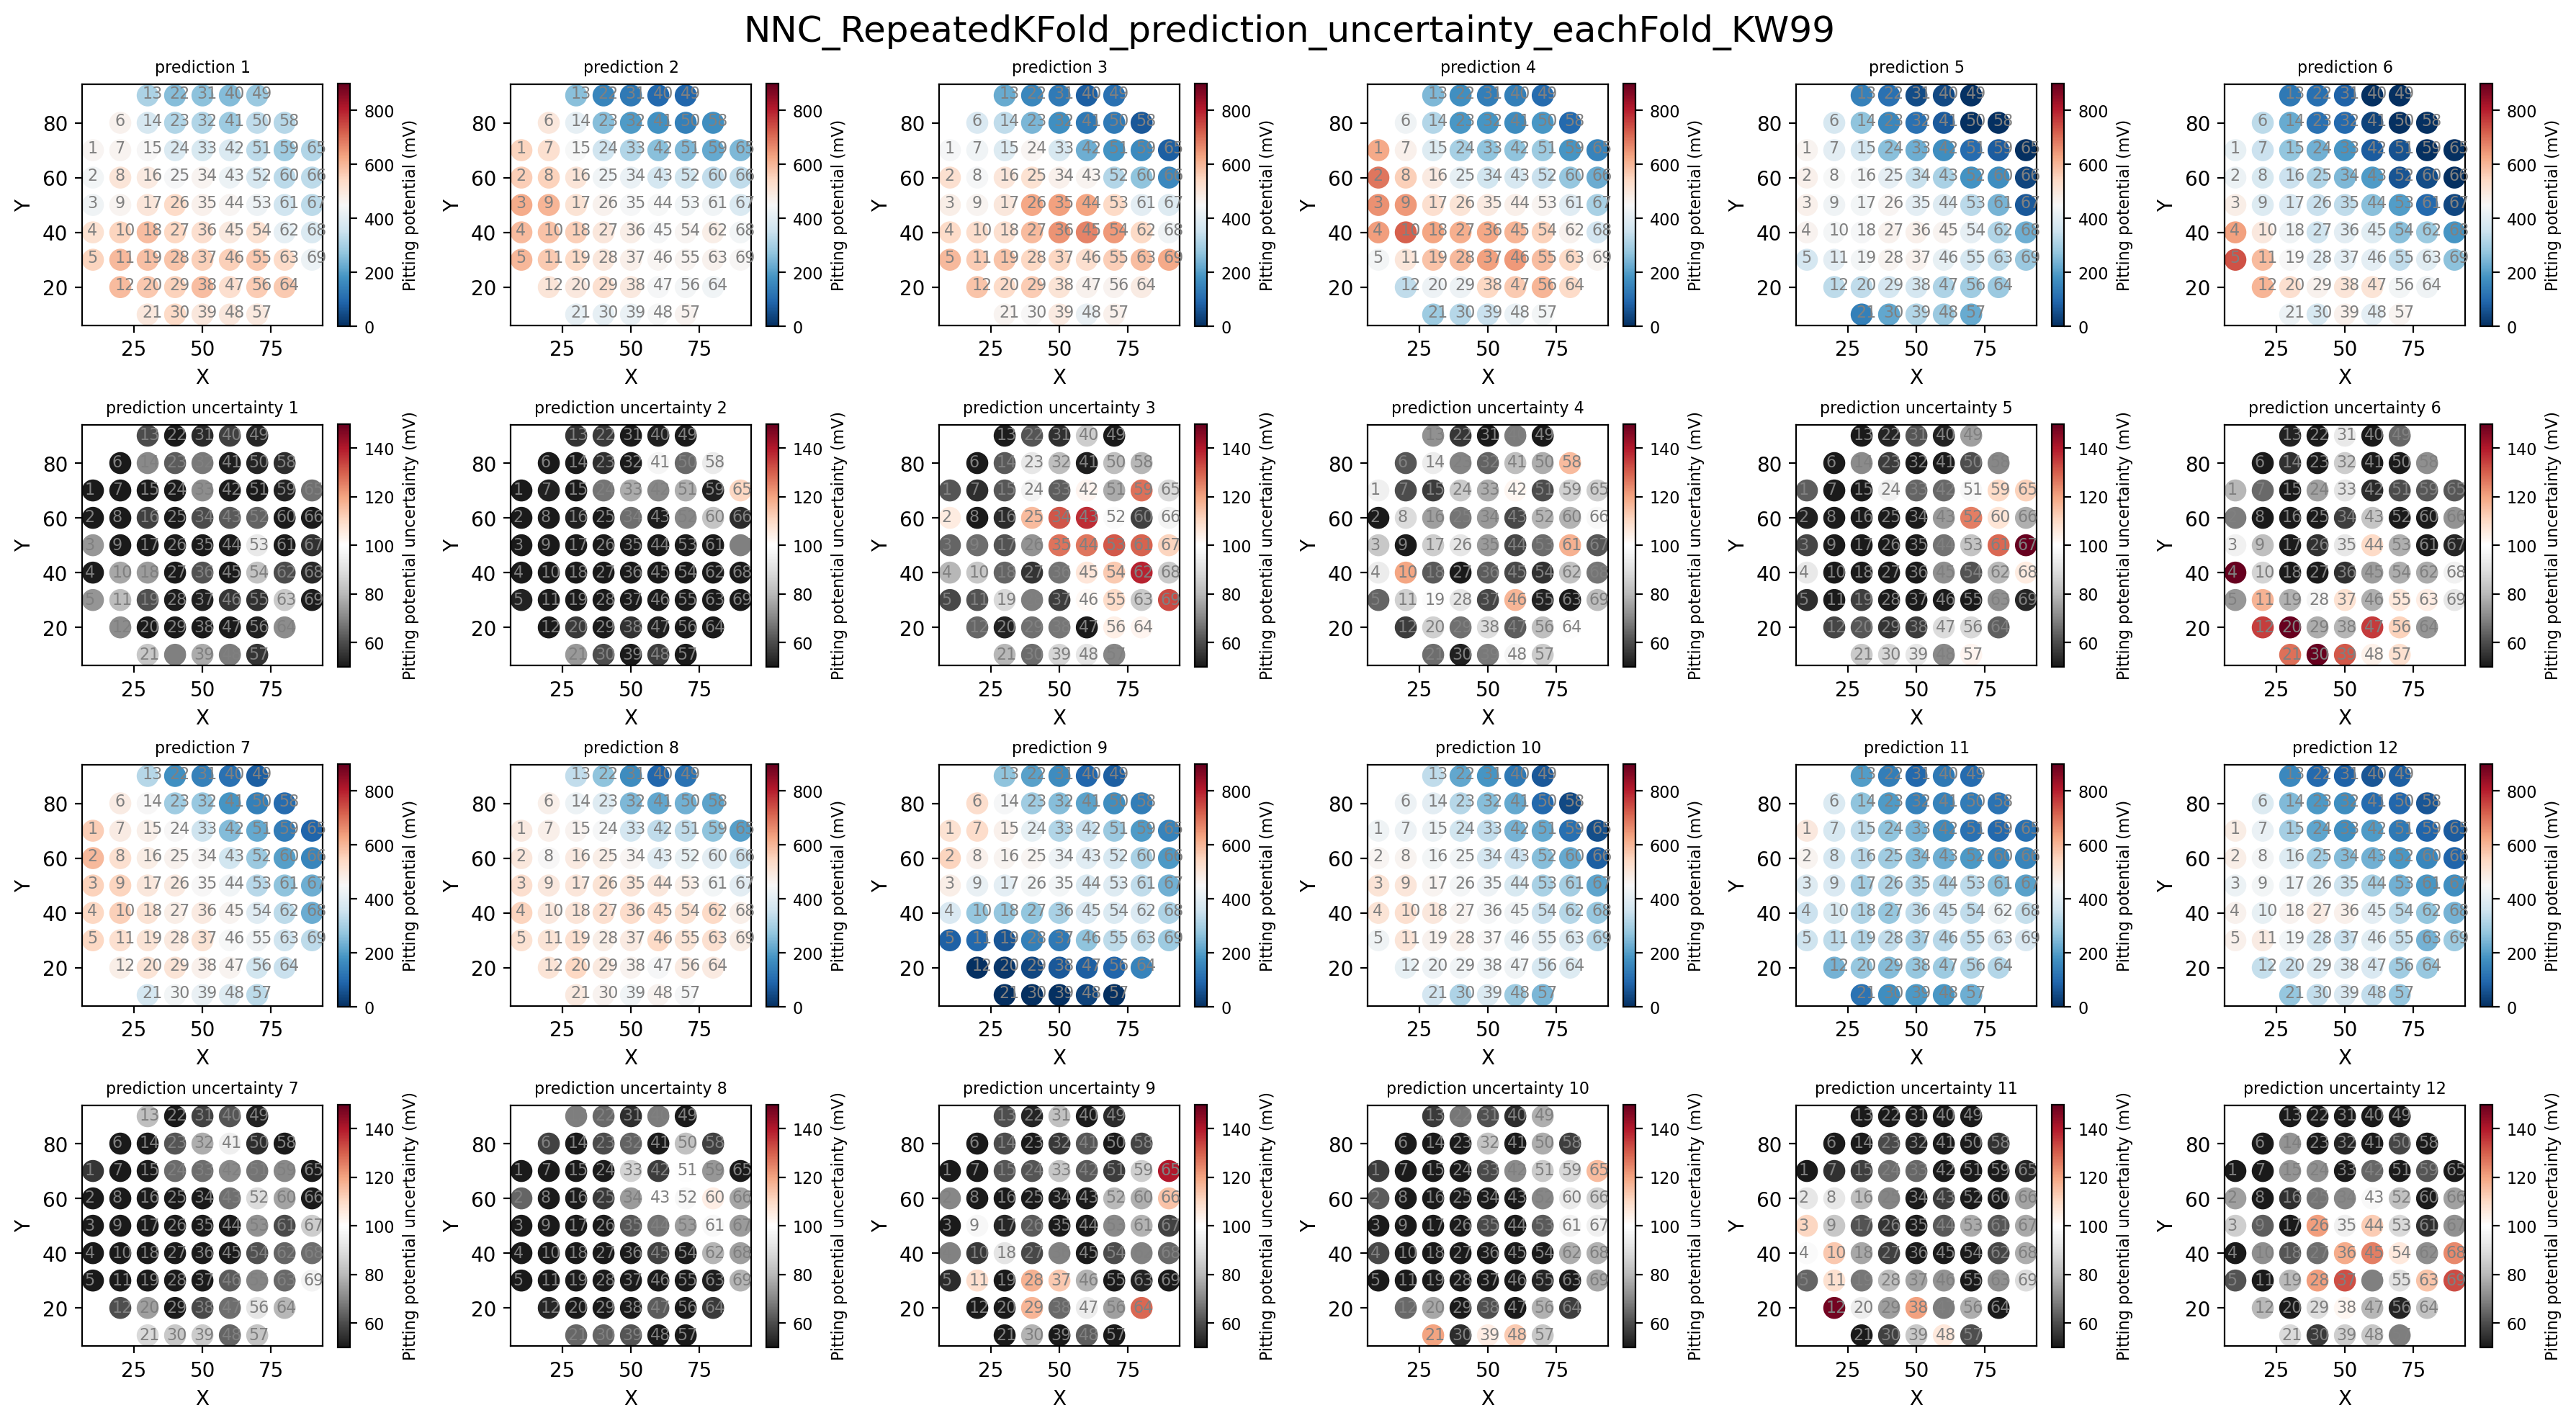

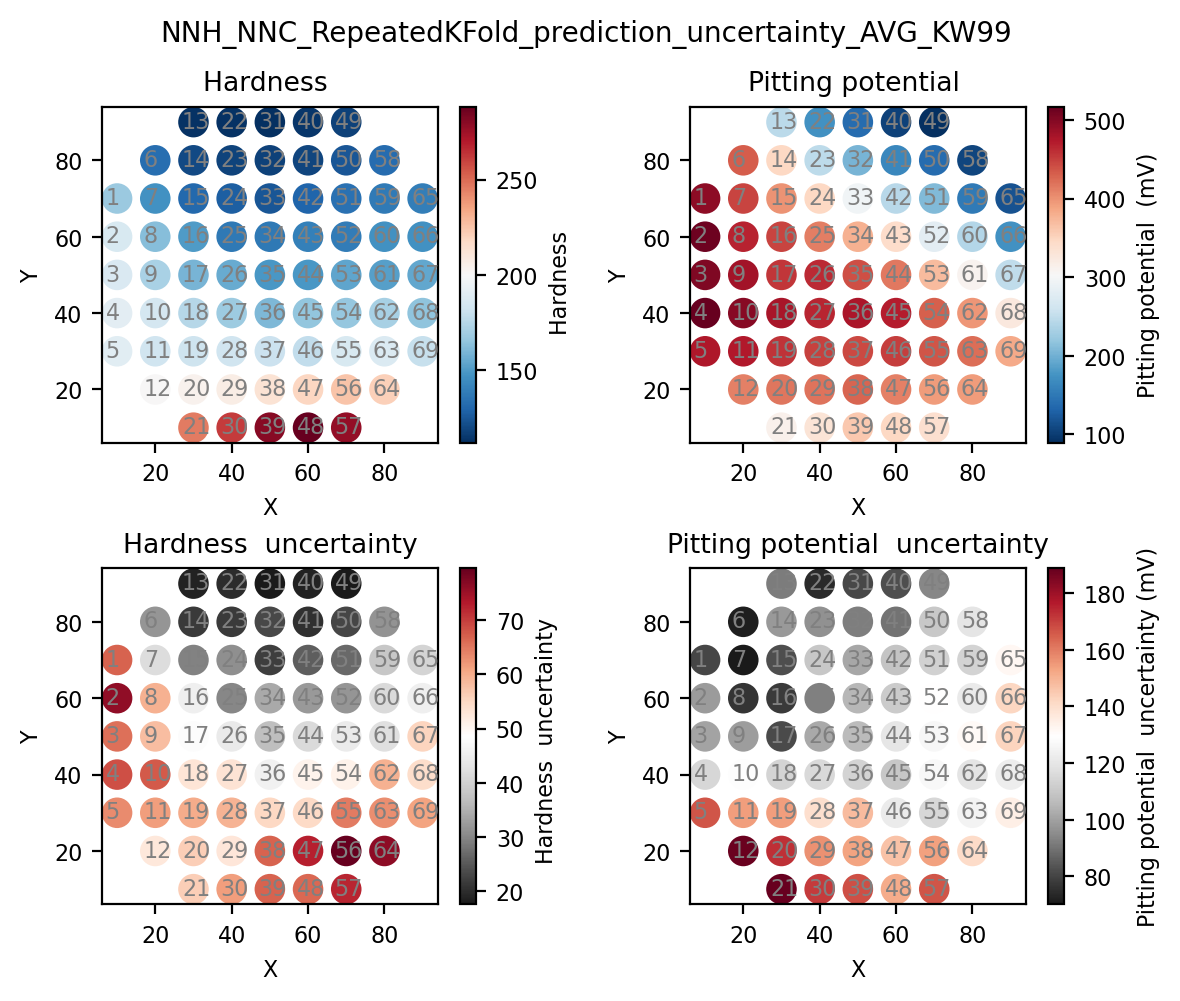

Processing:  50%|█████     | 1/2 [01:03<01:03, 63.76s/it]

['Ni', 'Cr', 'Mo', 'Ti', 'Fe']
KW131


2023-06-02 17:57:35.652440: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-02 17:57:35.652438: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-02 17:57:35.652438: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuil

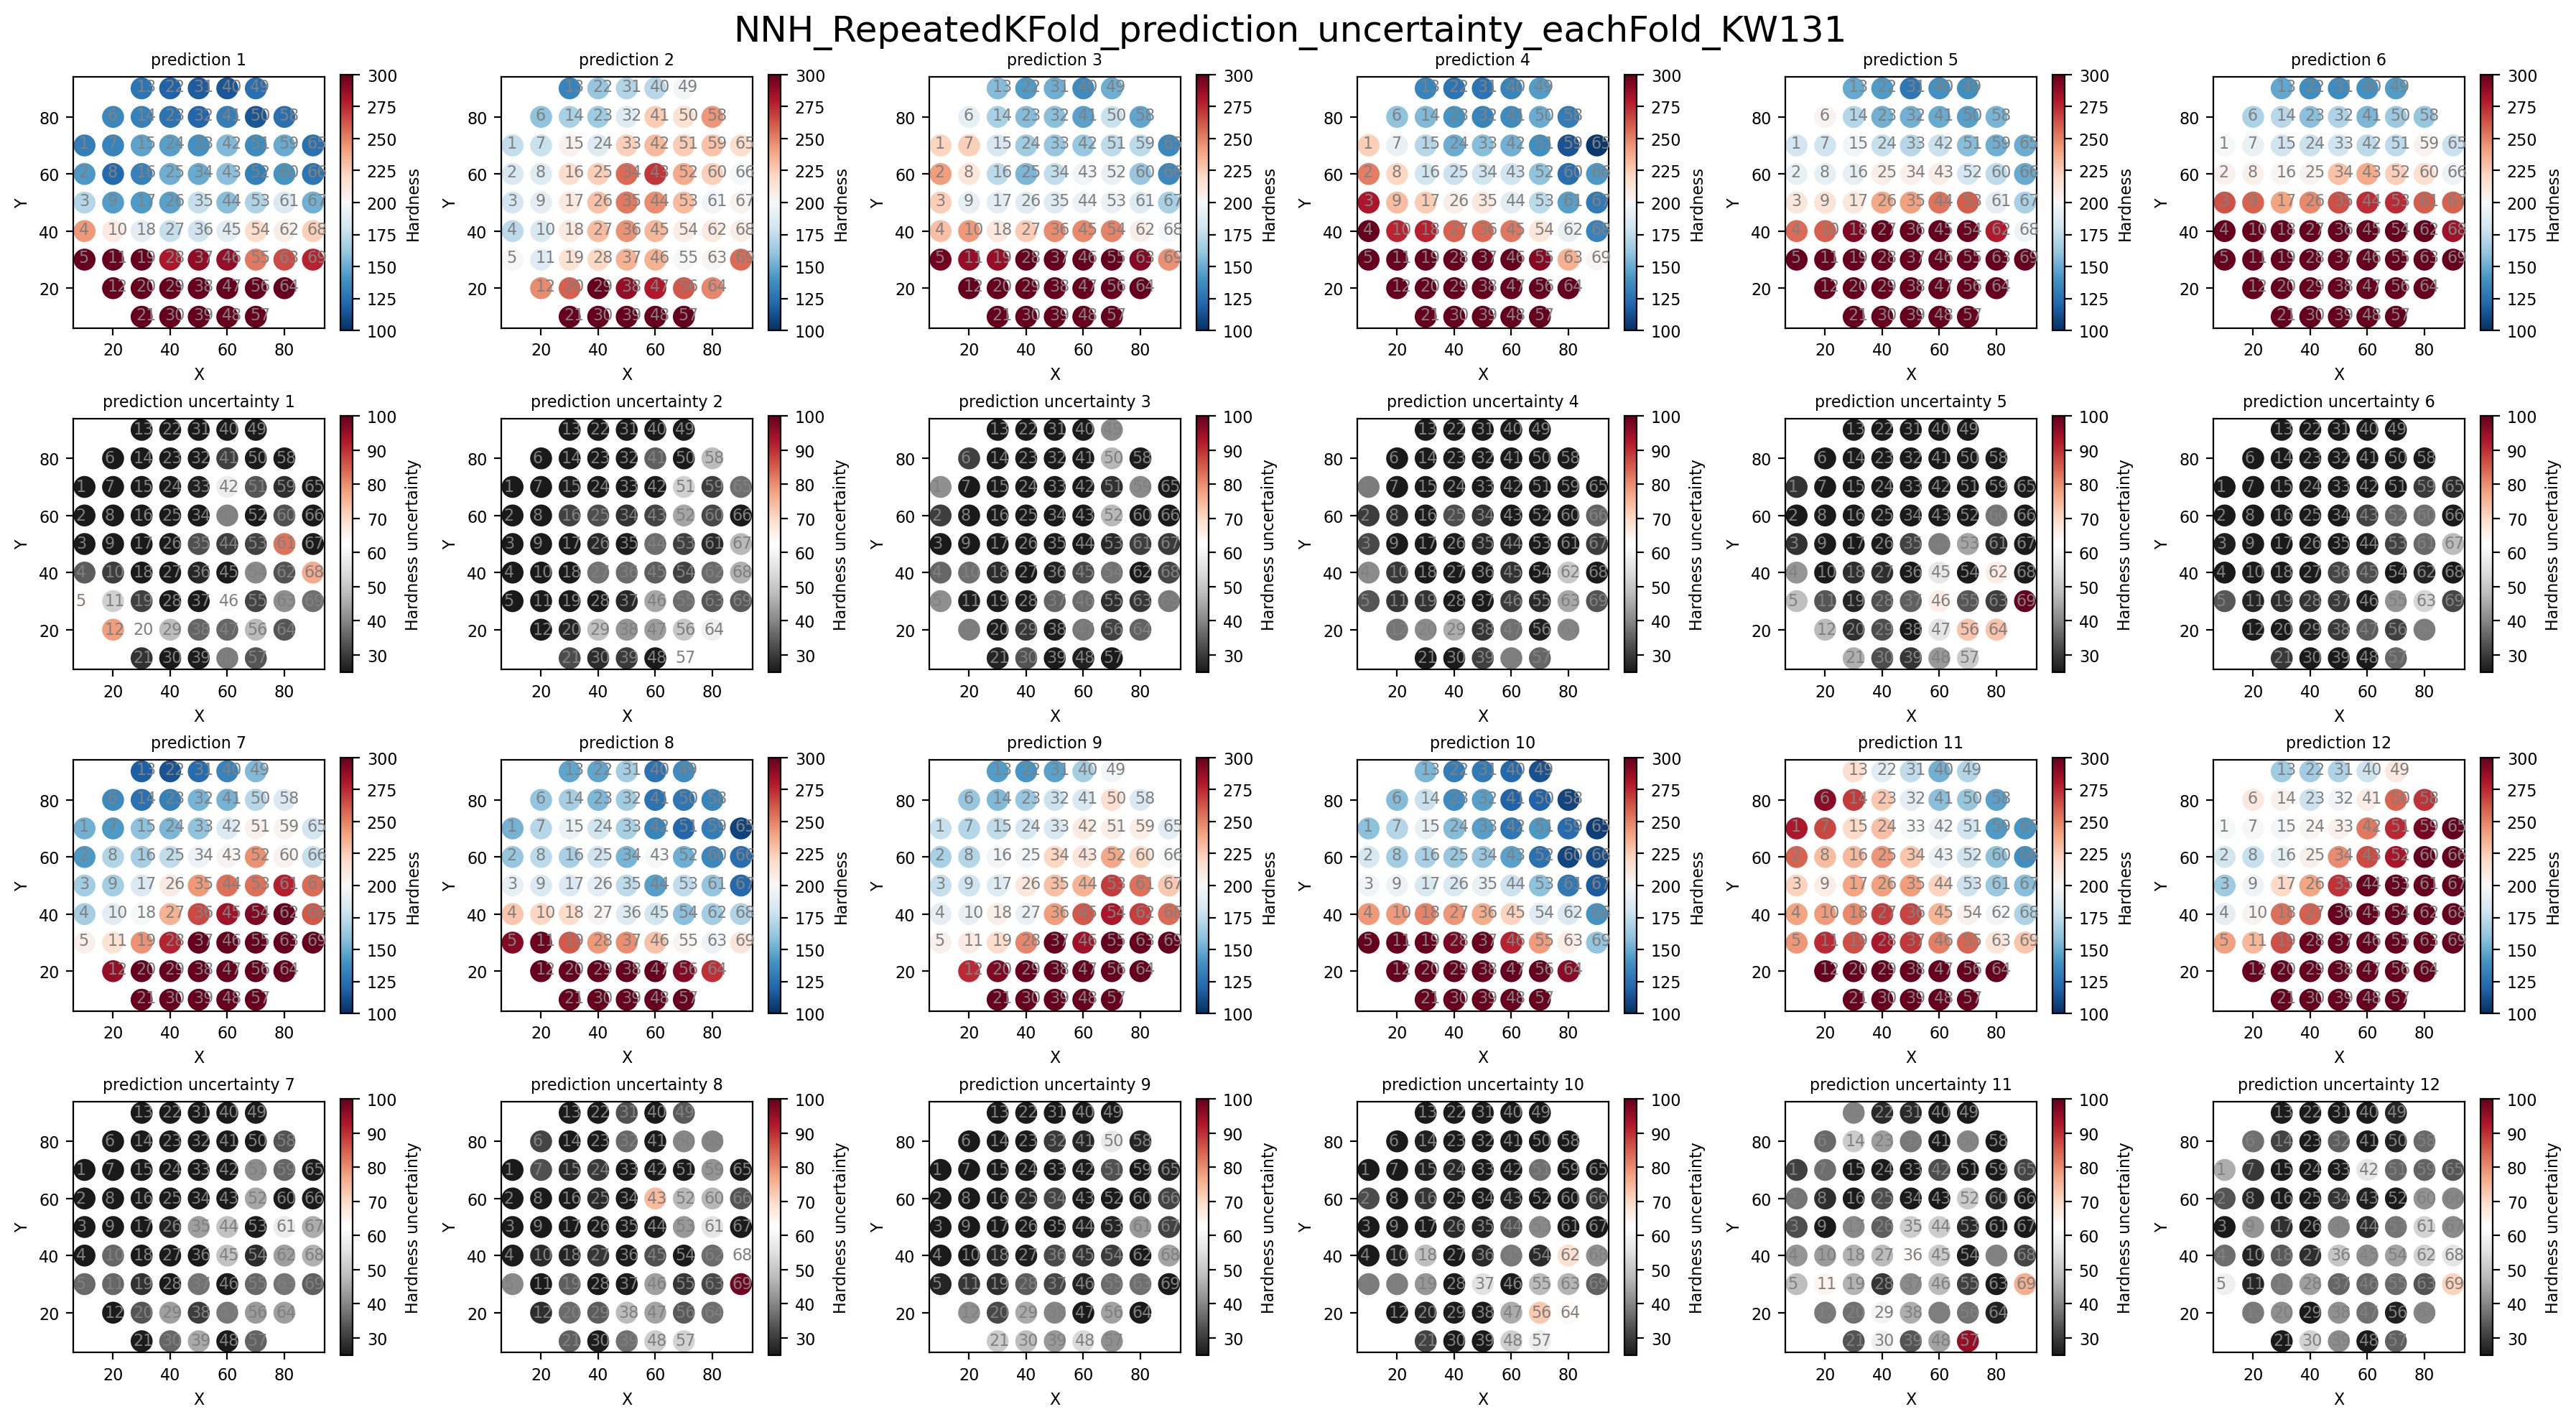

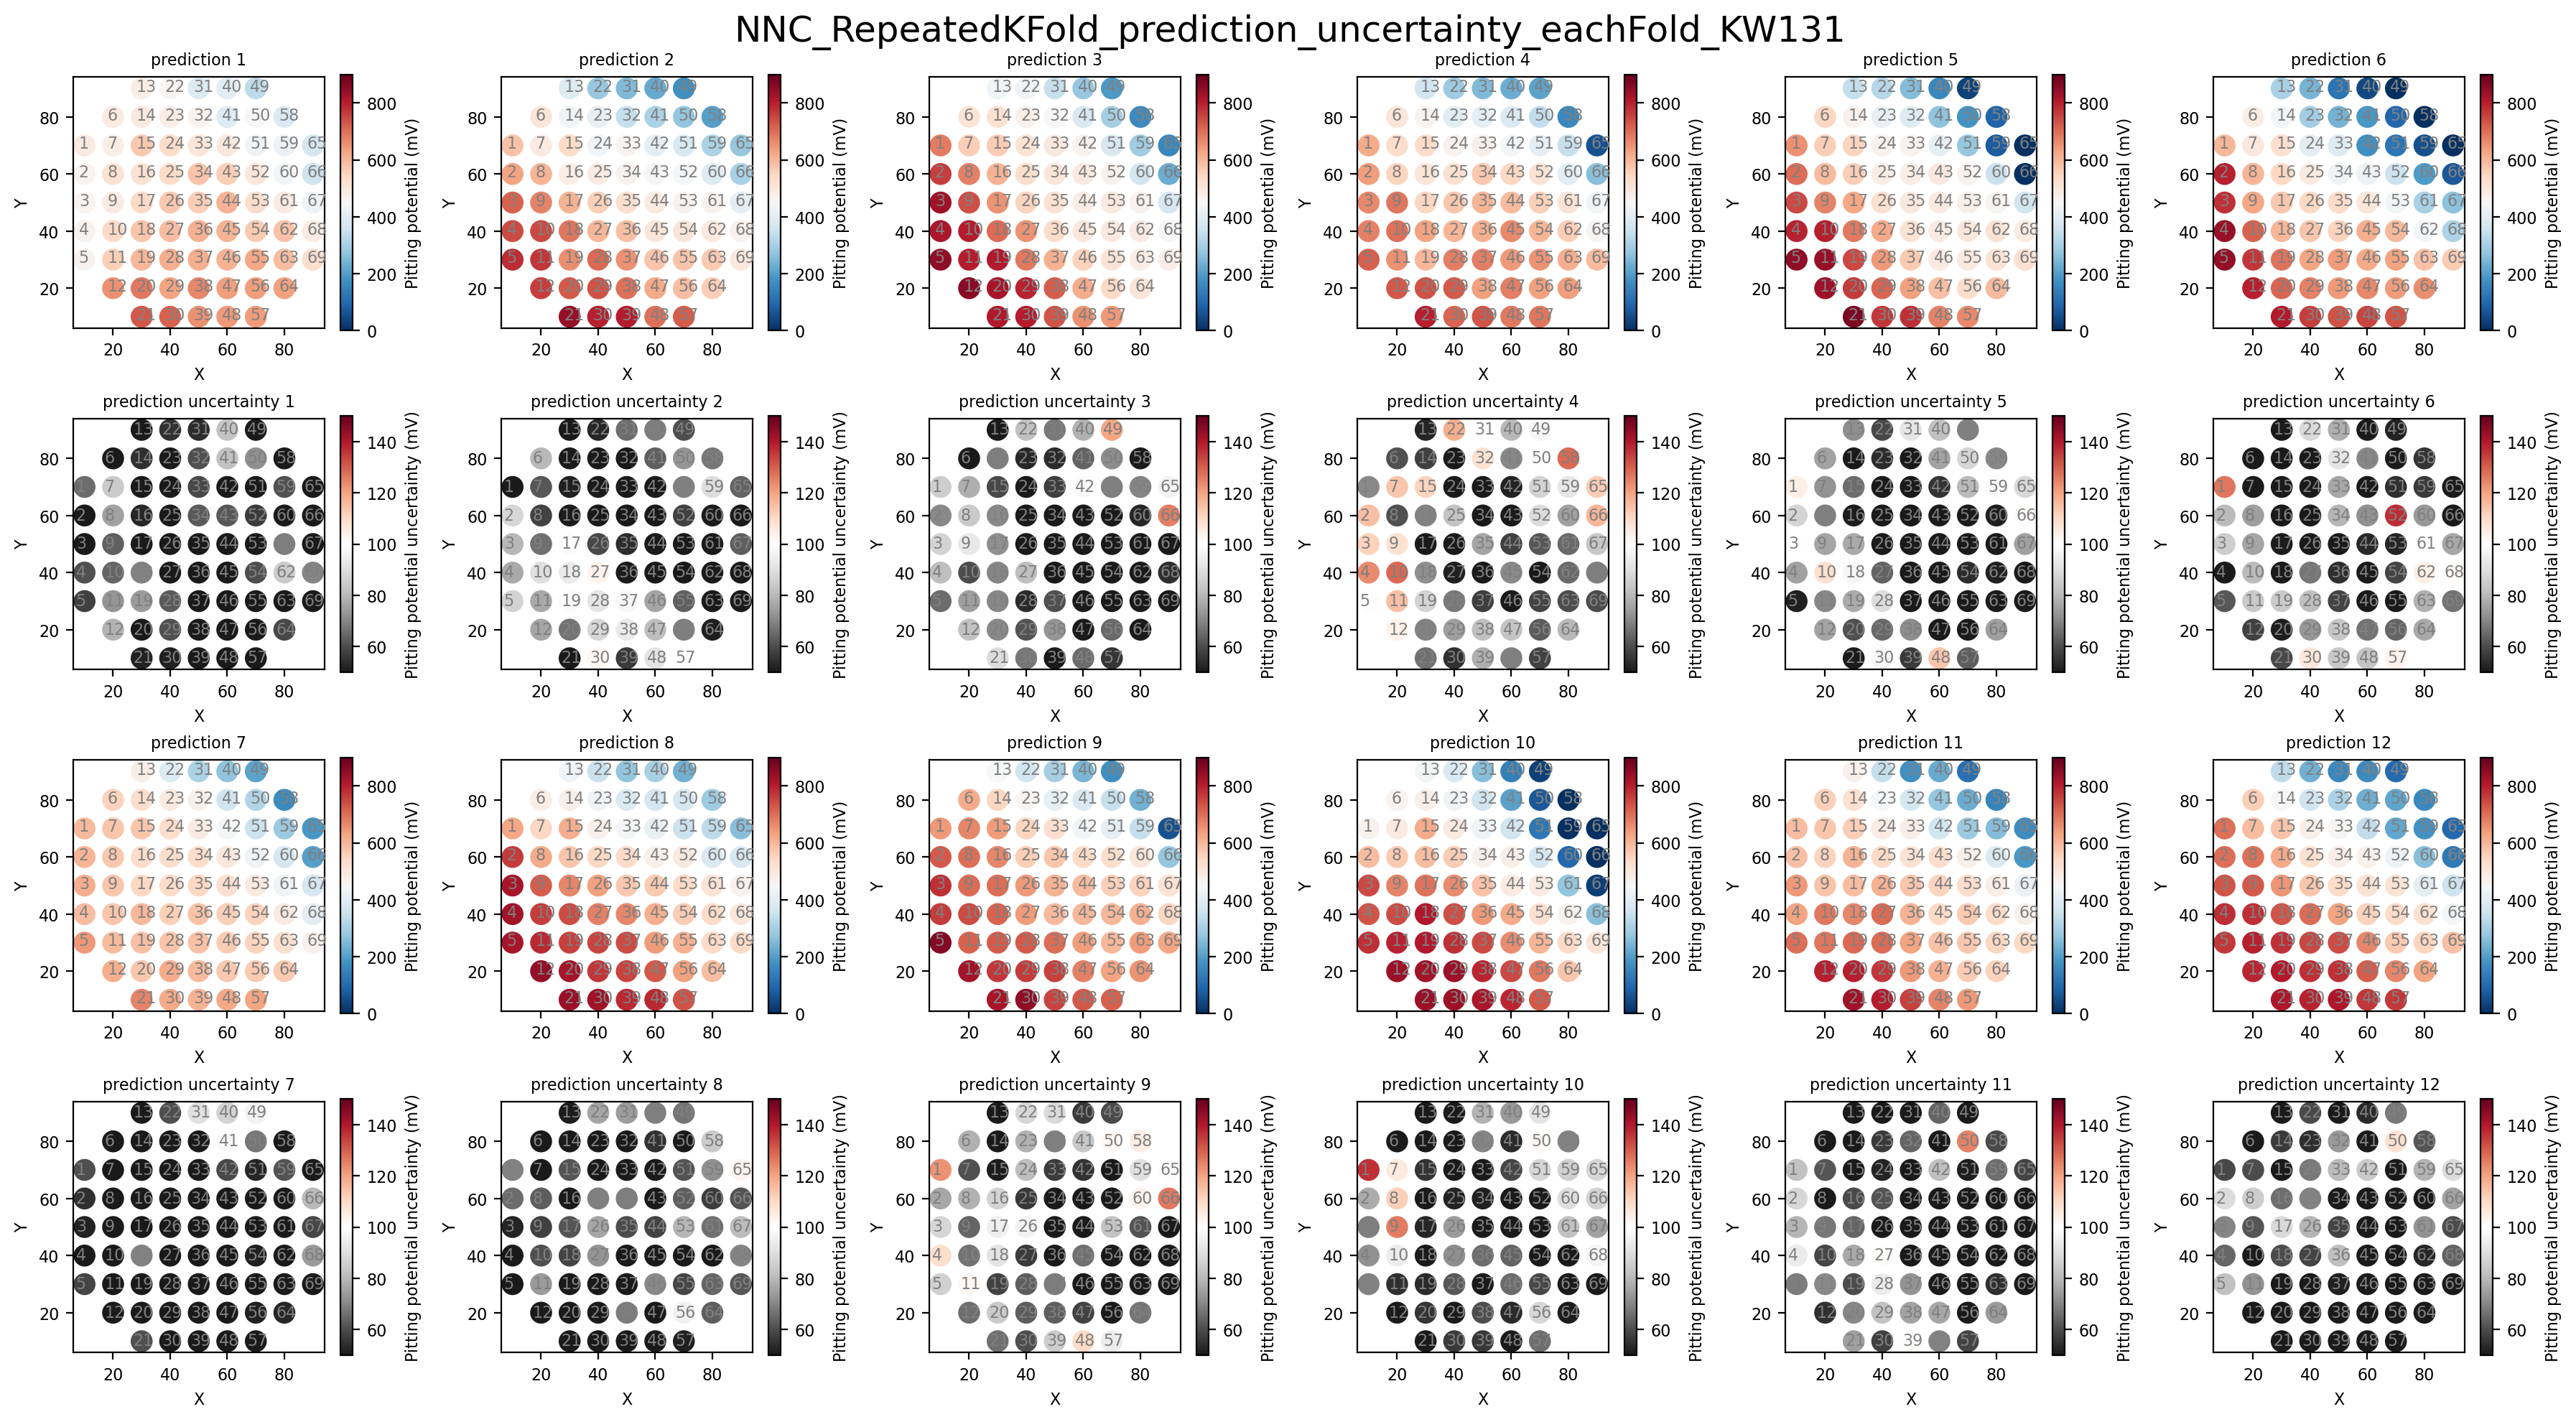

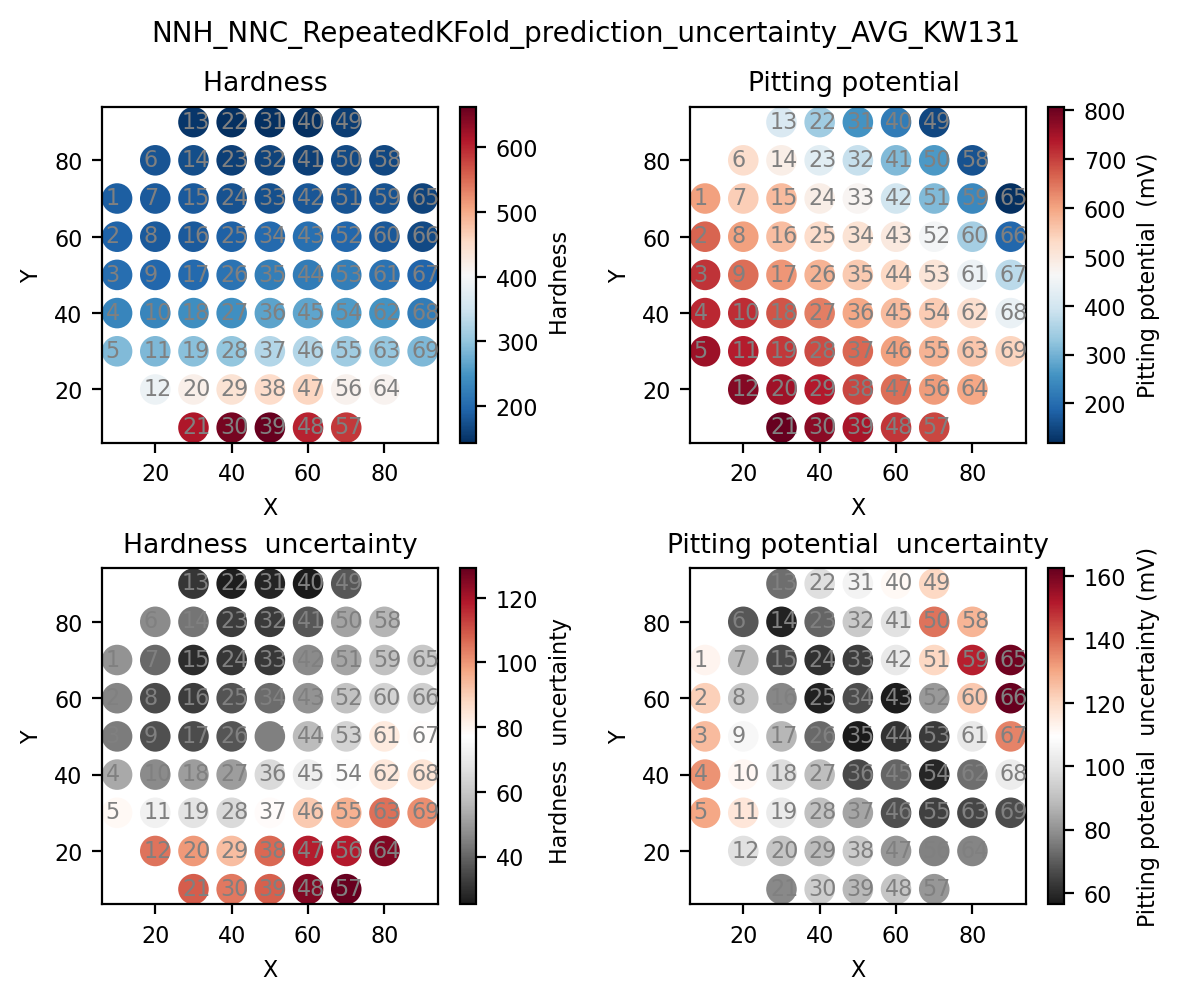

Processing: 100%|██████████| 2/2 [02:21<00:00, 70.62s/it]


In [10]:
from tqdm import tqdm

for compo_A_B_C_D_E, compo_A_B_C_D_E_fname in tqdm(zip(compo_A_B_C_D_E_list, compo_A_B_C_D_E_fname_list), desc='Processing', total=len(compo_A_B_C_D_E_list)):
    print(compo_A_B_C_D_E)
    print(compo_A_B_C_D_E_fname)

    df_new_at = pd.read_excel(newdata_path + 'v6_' + compo_A_B_C_D_E_fname + '_SSS_FCC_byCompo_at_pct.xlsx')
    df_new_wt = pd.read_excel(newdata_path + 'v6_' + compo_A_B_C_D_E_fname + '_SSS_FCC_byCompo_wt_pct.xlsx')
    vars_ele =  compo_A_B_C_D_E
        

    # ----- make predition -----
    k_folds     = 6
    n_CVrepeats = 2
    mc_repeat   = 10

    NNH_model_name = 'NNH_model_RepeatedKFold_{}.h5'
    NNC_model_name = 'NNC_model_RepeatedKFold_{}.h5'

    compo_new, H_specific_new, C_specific_new = read_new_data(df_new_at, df_new_wt, vars_ele)

    (H1_new_pred_stack, H1_new_pred_mean, H1_new_pred_std, 
    C2_new_pred_stack, C2_new_pred_mean, C2_new_pred_std) = predict_bootstrap_NNH_NNC(
                                                                model_path_bo, NNH_model_name, NNC_model_name,
                                                                compo_new, H_specific_new, C_specific_new,
                                                                scaler_compo, scaler_H_specific, scaler_C_specific, 
                                                                scaler_H_output, scaler_C_output,
                                                                k_folds, n_CVrepeats, mc_repeat)


    # ----- concatenate and compute mean and std + save to excel -----
    H1_new_pred_KFold_mean = np.mean(np.concatenate(H1_new_pred_stack, axis=0), axis=0).reshape(-1)
    H1_new_pred_KFold_std  = np.std(np.concatenate(H1_new_pred_stack, axis=0), axis=0).reshape(-1)
    C2_new_pred_KFold_mean = np.mean(np.concatenate(C2_new_pred_stack, axis=0), axis=0).reshape(-1)
    C2_new_pred_KFold_std  = np.std(np.concatenate(C2_new_pred_stack, axis=0), axis=0).reshape(-1)

    df_new_at['H1_new_pred_KFold_mean'] = H1_new_pred_KFold_mean
    df_new_at['H1_new_pred_KFold_std']  = H1_new_pred_KFold_std
    df_new_at['C2_new_pred_KFold_mean'] = C2_new_pred_KFold_mean
    df_new_at['C2_new_pred_KFold_std']  = C2_new_pred_KFold_std

    # display(df_new_at)
    df_new_at.to_excel(newdata_path + 'v6_' + compo_A_B_C_D_E_fname + '_SSS_FCC_byCompo_at_pct_ML.xlsx')

  
    # ----- plotting ----- 
    KW_name = compo_A_B_C_D_E_fname

    # NNH predictions
    pred_label, unc_label = 'Hardness', 'Hardness uncertainty'
    title                 = 'NNH_RepeatedKFold_prediction_uncertainty_eachFold_' + KW_name
    vmin1, vmax1          = 100, 300
    vmin2, vmax2          = 25, 100
    plot_prediction_uncertainty(coord_x, coord_y, index_PVD_x_y, H1_new_pred_mean, H1_new_pred_std, 
                                pred_label, unc_label, title, vmin1, vmax1, vmin2, vmax2, 
                                newdata_path)

    # NNC predictions
    pred_label, unc_label = 'Pitting potential (mV)', 'Pitting potential uncertainty (mV)'
    title                 = 'NNC_RepeatedKFold_prediction_uncertainty_eachFold_' + KW_name
    vmin1, vmax1          = 0,  900
    vmin2, vmax2          = 50, 150
    plot_prediction_uncertainty(coord_x, coord_y, index_PVD_x_y, C2_new_pred_mean, C2_new_pred_std, 
                                pred_label, unc_label, title, vmin1, vmax1, vmin2, vmax2, 
                                newdata_path)

    # NNH_NNC_AVG predictions
    title = 'NNH_NNC_RepeatedKFold_prediction_uncertainty_AVG_' + KW_name
    plot_prediction_uncertainty_AVG(coord_x, coord_y, index_PVD_x_y, H1_new_pred_stack, C2_new_pred_stack, 
                                    title, KW_name, 
                                    newdata_path)
 

In [11]:
# # ----- plotting -----
# # NNH predictions
# pred_label, unc_label = 'Hardness', 'Hardness uncertainty'
# title                 = 'NNH_RepeatedKFold_prediction_uncertainty_eachFold_' + KW_name
# vmin1, vmax1          = 100, 300
# vmin2, vmax2          = 25, 100
# plot_prediction_uncertainty(coord_x, coord_y, index_PVD_x_y, H1_new_pred_mean, H1_new_pred_std, 
#                             pred_label, unc_label, title, vmin1, vmax1, vmin2, vmax2, model_path_bo)

# # NNC predictions
# pred_label, unc_label = 'Pitting potential (mV)', 'Pitting potential uncertainty (mV)'
# title                 = 'NNC_RepeatedKFold_prediction_uncertainty_eachFold_' + KW_name
# vmin1, vmax1          = 0,  900
# vmin2, vmax2          = 50, 150
# plot_prediction_uncertainty(coord_x, coord_y, index_PVD_x_y, C2_new_pred_mean, C2_new_pred_std, 
#                             pred_label, unc_label, title, vmin1, vmax1, vmin2, vmax2, model_path_bo)

# # NNH_NNC_AVG predictions
# title = 'NNH_NNC_RepeatedKFold_prediction_uncertainty_AVG_' + KW_name
# plot_prediction_uncertainty_AVG(coord_x, coord_y, index_PVD_x_y, H1_new_pred_stack, C2_new_pred_stack, 
#                                 title, KW_name, model_path_bo)
